In [ ]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

# using high level interface
from cascade_model import cascade_sim
pars = {}
pars['neutrino_type']='nue'
pars['interaction_type']='CC'
pars['gamma']=1.1
pars['lEmin']=3.0
pars['lEmax']=7.0
s = cascade_sim(pars)

nsamples = int(1.e6)
outfile = './output/'+pars['neutrino_type']+'_'+pars['interaction_type']+'_simulation_gamma_'+str(pars['gamma'])+'_lEmin_'+str(pars['lEmin'])+'_lEmax_'+str(pars['lEmax'])+'_test_y.h5'
#s.run_simulation(nsamples, outfile)

['generation_weight' 'prim_coszenith' 'rec_coszenith' 'dep_energy'
 'rec_energy' 'prim_energy' 'prim_azimuth' 'rec_azimuth' 'bjorken_y']
rate: 22.61 pm 0.03


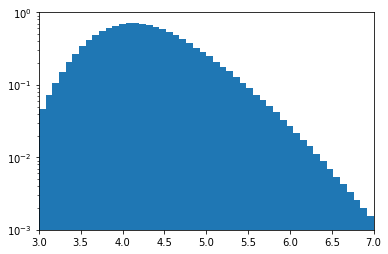

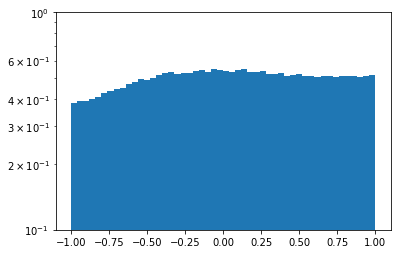

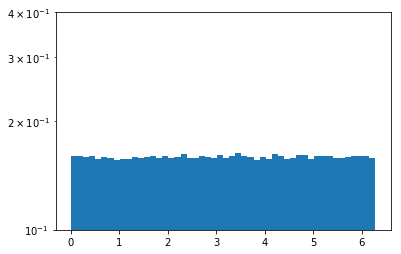

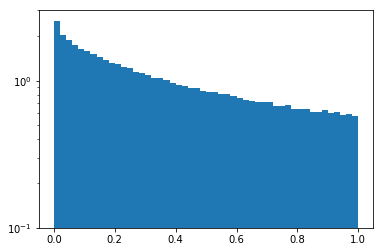

In [8]:
import pandas
import numpy as np

df = pandas.read_hdf(outfile)
print df.columns.values

# plot results 
from matplotlib import pyplot as plt
gamma = 2.5
norm = 1.*10**(-18)
ltime = 365. * 24. * 3600. * 2. # assume 2 years of livetime for rate

weights_plot=df['generation_weight']*np.power(df['prim_energy']/1.e5,-gamma)* norm * ltime

rate = np.sum(weights_plot)
rate_err = np.sqrt(np.sum((df['generation_weight']*np.power(df['prim_energy']/1.e5,-gamma) * norm * ltime)**2))
print "rate:", np.round(rate, 2), "pm", np.round(rate_err,2)



plt.hist(np.log10(df['prim_energy']), bins=50, weights=weights_plot, normed=True)
plt.ylim([1.e-3, 1.0])
plt.xlim([3.0, 7.0])
plt.yscale('log')
plt.show()

plt.hist(df['rec_coszenith'], bins=50, weights=weights_plot, normed=True)
plt.ylim([0.1,1])
plt.yscale('log')
plt.show()

plt.hist(df['rec_azimuth'], bins=50, weights=weights_plot, normed=True)
plt.ylim([0.1,0.4])
plt.yscale('log')
plt.show()

plt.hist(df['bjorken_y'], bins=50, weights=weights_plot, normed=True)
plt.ylim([0.1,3.0])
plt.yscale('log')
plt.show()

In [117]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

import pandas as pd
import numpy as np

neutrino_interaction = 'CC'
neutrino_flavor = 'nue'
nsamples = int(1.e6)
show = int(1.e1)

lEmin = 3.0
lEmax = 7.0
gamma_inj = 1.0


sim_component = neutrino_flavor + '_' + neutrino_interaction                                                        

if 'bar' in neutrino_flavor:
    ytype = 'nubar_'+neutrino_interaction
else:
    ytype = 'nu_'+neutrino_interaction


outfile = './output/'+sim_component+'_simulation_gamma_'+str(gamma_inj)+'_lEmin_'+str(lEmin)+'_lEmax_'+str(lEmax)+'.h5'
print outfile

./output/nue_CC_simulation_gamma_1.0_lEmin_3.0_lEmax_7.0.h5


In [95]:
# sample neutrino energies from powerlaw
from pareto_sampler.pareto import truncated_pareto
pareto = truncated_pareto(gamma, 10**lEmin, 10**lEmax)
neutrino_energies = pareto.samples(nsamples)
neutrino_energies_log = np.log10(neutrino_energies)
print neutrino_energies_log[:show]

[4.3307643  3.40537726 3.8776867  3.54448671 3.02584623 3.25869316
 3.13768348 3.70190326 3.03882038 4.33495296]


In [96]:
# sample neutrino directions uniformly across sky
from recodir_sampler.uniform_sampler import uniform_from_sphere, transform_to_cartesian, transform_to_spherical     
neutrino_directions = uniform_from_sphere(nsamples)
neutrino_directions_cartesian = transform_to_cartesian(neutrino_directions)                                         
neutrino_cos_thetas = np.asarray(neutrino_directions[:,0])
print neutrino_cos_thetas[:show]

[-0.28620141  0.79309703 -0.71801382 -0.08467633  0.48628468  0.05280389
 -0.09828795  0.17925679  0.13619678  0.81560081]


In [105]:
# setup y sampler and create y_samples
from inelasticity_sampler.draw_inelasticity import inelasticity_sampler                                             
from inelasticity_sampler.interaction_info import interaction_source_files                                          
source = interaction_source_files()
pickledir = './inelasticity_sampler/pickle/'

log_central_energy = 5.
kinematics_sampler = inelasticity_sampler(source, pickledir)                                                        
y_samples =  kinematics_sampler.sample_y(log_central_energy, ytype, nsamples)                                       
print y_samples[:show]

[0.02008067 0.01473626 0.34154286 0.02325939 0.08585389 0.21982758
 0.20135233 0.59749751 0.0780586  0.03147813]


In [97]:
# calculate weights
from aeff_calculator.aeff_calculator import effective_area
aeff = effective_area(sim_component)

effective_areas = np.power(10, np.asarray([aeff.eval(lE, ct) for lE,ct in zip(neutrino_energies_log, neutrino_cos_thetas)]))
effective_areas = effective_areas.flatten()
print effective_areas[:show]

weights = 1./nsamples * effective_areas / pareto.pdf(neutrino_energies) * 4. * np.pi * 10.**4
print weights[:show]

... creating effective area spline for interaction nue_CC , done!
[8.44428242e-01 8.68601716e-03 1.63763874e-01 3.10265867e-02
 3.23687333e-04 4.18595346e-03 1.75583498e-03 7.06802618e-02
 5.76060212e-04 8.63555219e-01]
[4.86696008e+04 7.05897495e+00 1.17154218e+03 4.78491092e+01
 4.58125638e-02 1.73119964e+00 4.15926970e-01 2.25045894e+02
 8.65515954e-02 5.07414031e+04]


In [106]:
# calculate energy deposit as function of interaction type and inelasticity
# this needs to be a function of the interaction type (NC, CC, hadronic light scale etc)
energy_deposits = neutrino_energies

# dummy energy resolution
# relative resolution needs to be a function of energy deposit
relative_resolution = 0.1
energy_resolutions = energy_deposits * relative_resolution
reconstructed_energies = np.random.normal(energy_deposits, energy_resolutions)
print reconstructed_energies[:show]

[24665.18989852  2268.80285577  8563.3015722   3342.18877021
  1345.72068448  2089.8489361   1493.10000894  5436.02557601
  1075.46855948 21271.32332753]


In [99]:
# dummy angular resolution
# concentration as function of energy deposit
from recodir_sampler.vMF_sampler import VonMisesFisher
err = 10. / 180. * np.pi
var = err**2
kappa = 2.3 / var
reconstructed_directions = []
vMF = VonMisesFisher()
for mu in neutrino_directions_cartesian:
    tdis = vMF.randomize_about_point(np.asarray([mu]), kappa=kappa, num_samples=1)
    reconstructed_directions.append(transform_to_spherical(tdis)[0])
print reconstructed_directions[:show]

[array([-0.22436195,  3.14071824]), array([0.86994836, 3.45562844]), array([-0.78355607,  0.911079  ]), array([0.06404752, 0.164083  ]), array([0.44631244, 4.31862908]), array([-0.08322258,  5.84601154]), array([-0.23921637,  1.71800708]), array([0.21008971, 5.78129402]), array([0.11707758, 4.19195605]), array([0.7886023 , 5.40096157])]


rate: 22.7 pm 0.06


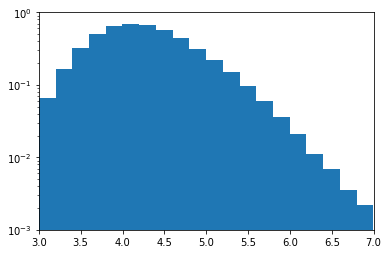

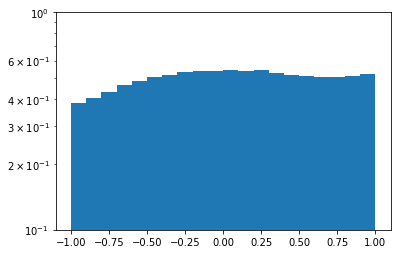

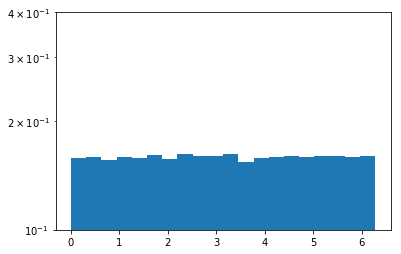

In [121]:
# plot results 
from matplotlib import pyplot as plt
gamma = 2.5
norm = 1.*10**(-18)
ltime = 365. * 24. * 3600. * 2. # assume 2 years of livetime for rate

weights_plot=weights*np.power(neutrino_energies/1.e5,-gamma)* norm * ltime

rate = np.sum(weights_plot)
rate_err = np.sqrt(np.sum((weights*np.power(neutrino_energies/1.e5,-gamma) * norm * ltime)**2))
print "rate:", np.round(rate, 2), "pm", np.round(rate_err,2)



plt.hist(neutrino_energies_log, bins=20, weights=weights_plot, normed=True)
plt.ylim([1.e-3, 1.0])
plt.xlim([3.0, 7.0])
plt.yscale('log')
plt.show()

dirs = np.vstack(reconstructed_directions)
plt.hist(dirs[:,0], bins=20, weights=weights_plot, normed=True)
plt.ylim([0.1,1])
plt.yscale('log')
plt.show()

dirs = np.vstack(reconstructed_directions)
plt.hist(dirs[:,1], bins=20, weights=weights_plot, normed=True)
plt.ylim([0.1,0.4])
plt.yscale('log')
plt.show()

In [120]:
# check all variables
print len(reconstructed_energies), np.amin(reconstructed_energies), np.amax(reconstructed_energies)
print len(neutrino_energies), np.amin(neutrino_energies), np.amax(neutrino_energies)
print len(neutrino_directions[:,0]), np.amin(neutrino_directions[:,0]),np.amax(neutrino_directions[:,0])
print len(neutrino_directions[:,1]), np.amin(neutrino_directions[:,1]),np.amax(neutrino_directions[:,1])
print len(dirs[:,0]), np.amin(dirs[:,0]),np.amax(dirs[:,0])
print len(dirs[:,1]), np.amin(dirs[:,1]),np.amax(dirs[:,1])
print len(weights), np.amin(weights),np.amax(weights)
print len(energy_deposits), np.amin(energy_deposits), np.amax(energy_deposits)
print len(y_samples), np.amin(y_samples), np.amax(y_samples)

1000000 589.0607464375191 10460518.107152205
1000000 1000.0015856561567 9937354.15266665
1000000 -0.9999997895895614 0.9999944180282598
1000000 8.903794644131903e-07 6.283167601776304
1000000 -0.9999985506277503 0.999998770229043
1000000 4.523910606124559e-06 6.283168608407917
1000000 0.018279950201248896 341938826345.39246
1000000 1000.0015856561567 9937354.15266665
1000000 9.881588726287432e-16 0.9999998160983923


In [125]:
# write to pandas data frame

to_store={}
to_store["prim_energy"]=np.asarray(neutrino_energies)
to_store["prim_coszenith"]=np.asarray(neutrino_directions[:,0])
to_store["prim_azimuth"]=np.asarray(neutrino_directions[:,1])
to_store["rec_energy"]=np.asarray(reconstructed_energies)
to_store["rec_coszenith"]=np.asarray(dirs[:,0])
to_store["rec_azimuth"]=np.asarray(dirs[:,1])
to_store["generation_weight"]=np.asarray(weights)
to_store["dep_energy"]=np.asarray(energy_deposits)
to_store["bjorken_y"]=np.asarray(y_samples)

names = to_store.keys()
X = np.hstack(tuple([to_store[key].reshape(to_store[key].shape[0], -1) for key in names]))
df = pd.DataFrame(X, columns=names)
store = pd.HDFStore(outfile)
store[sim_component]=df
store.close()

In [132]:
# read pd frame back in

df = pd.read_hdf(outfile)
print len(df['prim_energy'].values), df['prim_energy'].values
print len(df['prim_azimuth'].values), df['prim_azimuth'].values

1000000 [21417.2793305   2543.18095539  7545.47693299 ...  5911.77664653
  1412.44882916  6839.24133303]
1000000 [0.02630842 0.74809005 4.10895873 ... 2.21414588 4.23535106 0.16224532]


In [129]:
ls

aeff_calculator/  csms_input/            output/           temp/
aeff_input/       example.ipynb          pareto_sampler/   TODO
cascade_model.py  inelasticity_sampler/  recodir_sampler/  Untitled.ipynb


nue_CC_simulation_gamma_1.0_lEmin_3.0_lEmax_7.0.h5


In [1]:
# using high level interface
from cascade_model import cascade_sim
pars = {}
pars['neutrino_type']='nue'
pars['interaction_type']='CC'
pars['gamma']=1.1
pars['lEmin']=3.0
pars['lEmax']=7.0
s = cascade_sim(pars)

nsamples = int(1.e6)
outfile = './output/'+pars['neutrino_type']+'_'+pars['interaction_type']+'_simulation_gamma_'+str(pars['gamma'])+'_lEmin_'+str(pars['lEmin'])+'_lEmax_'+str(pars['lEmax'])+'_test_y.h5'
s.run_simulation(nsamples, outfile)

Welcome to JupyROOT 6.14/04
... setting up all samplers
... setting up powerlaw sampler
done.
... setting up effective area
... creating effective area spline for interaction nue_CC , done!
done.
... setting up inelasticity sampler
done
... setting up directional sampler
all done!
... starting simulation for 1000000 events
... writing output to file
done!


['generation_weight' 'prim_coszenith' 'rec_coszenith' 'dep_energy'
 'rec_energy' 'prim_energy' 'prim_azimuth' 'rec_azimuth' 'bjorken_y']
rate: 22.61 pm 0.03


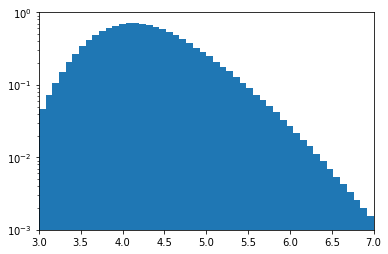

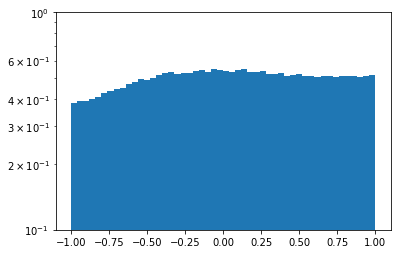

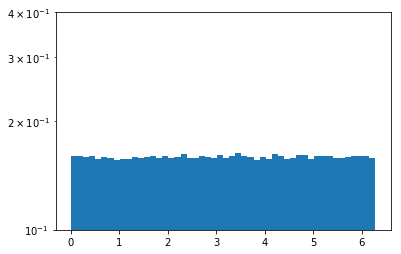

In [4]:
import pandas
import numpy as np

df = pandas.read_hdf(outfile)
print df.columns.values

# plot results 
from matplotlib import pyplot as plt
gamma = 2.5
norm = 1.*10**(-18)
ltime = 365. * 24. * 3600. * 2. # assume 2 years of livetime for rate

weights_plot=df['generation_weight']*np.power(df['prim_energy']/1.e5,-gamma)* norm * ltime

rate = np.sum(weights_plot)
rate_err = np.sqrt(np.sum((df['generation_weight']*np.power(df['prim_energy']/1.e5,-gamma) * norm * ltime)**2))
print "rate:", np.round(rate, 2), "pm", np.round(rate_err,2)



plt.hist(np.log10(df['prim_energy']), bins=50, weights=weights_plot, normed=True)
plt.ylim([1.e-3, 1.0])
plt.xlim([3.0, 7.0])
plt.yscale('log')
plt.show()

plt.hist(df['rec_coszenith'], bins=50, weights=weights_plot, normed=True)
plt.ylim([0.1,1])
plt.yscale('log')
plt.show()

plt.hist(df['rec_azimuth'], bins=50, weights=weights_plot, normed=True)
plt.ylim([0.1,0.4])
plt.yscale('log')
plt.show()